In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
import hydra
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

from utils import load_states_from_checkpoint
from data_utils.s2s_dataset import load_jsonl_data, S2S_dataset
from model_utils.create_model import create_model, create_gaussian_diffusion
from generate import denoised_fn_round

/home/gcilleru/ProphetNet/AR-diffusion/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# fake torch distributed
from torch import distributed as dist
from torch.nn.parallel import DistributedDataParallel

def initialize_distributed():
    if not dist.is_initialized():
        # Initialize the distributed environment
        dist.init_process_group(backend='gloo')  # 'gloo' is suitable for local development

# Call the initialization function
os.environ['RANK'] = '0'
os.environ['WORLD_SIZE'] = '1' 
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '1235'
initialize_distributed()

# Now you can use distributed functions safely
rank = dist.get_rank()
print(f"Rank {rank} reporting in!")

Rank 0 reporting in!


In [6]:
task = "d1_l2-50"
run = "eb2_d2_c128_wd01"
# task = "recipes"
# run = "eb6_d6_c128_wd01"
# if hydra initialized, clear it
if hydra.core.global_hydra.GlobalHydra.instance() is not None:
    hydra.core.global_hydra.GlobalHydra.instance().clear()
# hydra.initialize(config_path=f"experiment_configs/modulus/{task}")
# config = hydra.compose(config_name=f"{run}.yaml")
hydra.initialize(config_path=f".")
config = hydra.compose(config_name=f"config.yaml")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 4
print(config)
tokenizer = AutoTokenizer.from_pretrained(config.tokenizer.name_or_path)
vocab_size = tokenizer.vocab_size
eval_model_path = f"my_output/{task}/{run}/model/model_checkpoint-40000"
print("Load model from: ", eval_model_path)

/tmp/ipykernel_2680979/4219776525.py:10: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path=f".")


{'exp': {'seed': 101, 'root': './my_output', 'name': 'eb2_d2_c128_wd01', 'dir': None}, 'data': {'path': 'data/raw/dyck', 'name': 'd1_l2-50'}, 'tgt_len': 128, 'max_pos_len': 128, 'batch_size': 128, 'device': 'cuda', 'lr_step': 40000, 'warmup_steps': 4000, 'total_steps': 60000, 'lr': 0.0008, 'weight_decay': 0.1, 'grad_clip': -1.0, 'ema_rate': 0.9999, 'grad_accum': 1, 'eval_interval': 500, 'log_interval': 500, 'save_interval': 20000, 'model': {'mode': 's2s', 'pretrain': None}, 'tokenizer': {'from_pretrained': True, 'name_or_path': 'bert-base-uncased'}, 'encoder': {'initialize_from_pretrained': True, 'layers': 2, 'num_attention_heads': 4, 'att_dropout': 0.1, 'is_frozen': False}, 'denoiser': {'layers': 2, 'num_attention_heads': 4, 'att_dropout': 0.1}, 'time_channels': 128, 'in_channels': 128, 'out_channels': 128, 'diffusion_steps': 2000, 'vocab_size': 30522, 'intermediate_size': 3072, 'num_attention_heads': 4, 'hidden_size': 768, 'schedule_sampler': 'uniform', 'fairseq': {'use_fairseq': Fal

In [7]:
# create model and load it to device
diffusion = create_gaussian_diffusion(config)
model = create_model(config, vocab_size)
model_saved_state = load_states_from_checkpoint(eval_model_path, dist.get_rank())
model.load_state_dict(model_saved_state.model_dict)
# model.to(device)
# sample text from random noise
if config.ddim_sample:
    sample_fn = (diffusion.ddim_sample_loop)
else:
    sample_fn = (diffusion.p_sample_loop)
# word embedding
emb_model = model.word_embedding
model.to(device)

INFO:model_utils.create_model:noise_schedule: sqrt
INFO:model_utils.create_model:diffusion steps: 2000
INFO:model_utils.create_model:betas: [0.01464131 0.00888909 0.00706818 ... 0.35722328 0.55561113 0.999     ]
INFO:model_utils.create_model:Diffusion Loss Type: LossType.E2E_MSE
INFO:model_utils.create_model:Whether to learn sigma: False
INFO:model_utils.create_model:Diffusion predict xstart: True
INFO:model_utils.create_model:training mode is: s2s
INFO:model_utils.create_model:creating vanilla model with 2 encoder layers and 2 denoiser layers
INFO:model_utils.create_model:loading encoder pretrained BERT model True
INFO:model_utils.create_model:rescaling timesteps True
INFO:model_utils.create_model:using self condition False
INFO:model_utils.create_model:learning time position False
INFO:model_utils.create_model:fixing encoder False


INFO:model_utils.diffusion_lm:Load pretrained bert encoder with 2 layers.
INFO:utils:Reading saved model from my_output/d1_l2-50/eb2_d2_c128_wd01/model/model_checkpoint-40000
INFO:utils:model_state_dict keys dict_keys(['model_dict', 'optimizer_dict', 'scheduler_dict', 'offset'])


CrossAttention_Diffusion_LM(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [18]:
data_piece = [
    {
        "src":"[M][][][][[]][][][][][][[[[[[][[]][]]]]]][[]][[]][][][][[[[[[]]]]]]",
        "tgt":"[][]][[[]][[]][]][][][[]][]["
    },
    {
        "src":"[[M]",
        "tgt":"[]]"
    }
    # {
    #     "src":"25 - 63",
    #     "tgt":"88"
    # },
    # {
    #     "src":"57 - 33",
    #     "tgt":"90"
    # },
    # {
    #     "src":"102 - 109",
    #     "tgt": "98"
    # },

    # {
    #     "src": "Mandarin Spinach Salad Ingredients:  [MASK]  Directions: -Mix 2 tablespoons sugar with small amount of water over low heat until sugar has melted. -Add almonds and stir until well coated. -Cook, then break apart. -Store at room temperature. -In large bowl, place lettuce, spinach, celery and onions. Immediately before serving, toss with Sweet-Sour Dressing. -Then add mandarin oranges and almonds. -Don't add Sweet-Sour Dressing until ready to serve; it will make the salad soggy.",
    #     "tgt":"1/4 c. sliced almonds 1 head lettuce, torn into small pieces 1 bag spinach, torn into small pieces 2 medium stalks celery, chopped 2 green onions, thinly sliced 1 (11 oz.) can mandarin oranges, drained hard-boiled eggs (optional)"
    # },
    # {
    #     "src":"Prune Bread Ingredients: 1 1/2 cups prunes dried, - without pits 2 cups all purpose flour 3/4 cup sugar 1 teaspoon baking soda 1/2 teaspoon salt 1 egg 2 tablespoons shortening melted Directions: -In medium saucepan, combine prunes with 1 1/2 cups water, bring to boiling. Reduce heat, and simmer, covered. 10 minutes. -Preheat oven 350 degrees. -[MASK] -Let cool in pan on wire rack 10 minutes. Remove from pan: cool completely on rack. Wrap in plastic film or foil, and refrigerate overnight before slicing.",
    #     "tgt":"Sift flour with sugar, baking soda and salt; set aside. -Drain prunes, reserving liquid. Chop prunes or place in food processor and give a few good chops. -Add to reserved liquid, and measure. Add water if needed to make 2 cups. -In a large bowl combine egg and shortening: with electric mixer at medium speed, beat well. Add prune mixture: beat until well blended. -Add flour mixture: beat at low speed just until smooth. Turn into prepared pan. -Bake 50-60 minutes, or until cake tester inserted in center comes out clean."
    # },
    # {
    #     "src":"No Bake Chocolate Cookies Ingredients: 1/4 lb. margarine 1/2 c. milk 1/2 c. chocolate bits 2 c. sugar 3 c. oatmeal 1/2 c. peanut butter 1 tsp. vanilla Directions: -[MASK] -Remove from heat and add oatmeal, peanut butter and vanilla. -Cool slightly and drop by teaspoons on waxed paper.",
    #     "tgt": "Bring butter, milk, chocolate and sugar to a boil in a large saucepan. Boil and stir continuously for 1 minute."
    # }
    # {
    #     "src": "non mcdowell explosion",
    #     "tgt": "explosion mcdowell non",
    # },
    # {
    #     "src": "angels aldo ##oulos slovenian",
    #     "tgt": "slovenian ##oulos aldo angels",
    # },
    # {
    #     "src": "eased mention ##bine outcomes ##efe aldo ##糹 jumped ##claim weakness",
    #     "tgt": "weakness ##claim jumped ##糹 ##efe outcomes ##bine mention ##aldo eased",
    # },
    # {
    #     "src":"332 irritation halftime transitional escaping explosion wehrmacht mention flavors eased agrarian charlton appropriately europa dissemination publicized achieved intensity churchyard slaves ェ",
    #     "tgt":"ェ slaves churchyard intensity achieved publicized dissemination europa appropriately charlton agrarian eased flavors mention wehrmacht explosion escaping transitional halftime irritation 332"
    # },
    # {
    #     "src":"irritation halftime transitional escaping explosion wehrmacht elector mention flavors eased agrarian charlton appropriately europa dissemination publicized achieved intensity churchyard slaves ェ",
    #     "tgt":"ェ slaves churchyard intensity achieved publicized dissemination europa appropriately charlton agrarian eased flavors mention elector wehrmacht explosion escaping transitional halftime irritation"
    # },
    # {
    #     "src":"irritation halftime transitional escaping explosion wehrmacht bee mention flavors eased agrarian charlton appropriately europa dissemination publicized achieved intensity churchyard slaves ェ",
    #     "tgt":"ェ slaves churchyard intensity achieved publicized dissemination europa appropriately charlton agrarian eased flavors mention bee wehrmacht explosion escaping transitional halftime irritation"
    # },
    # {
    #     "src":"electors deliberate irritation halftime transitional escaping explosion wehrmacht mention flavors eased agrarian charlton appropriately europa dissemination publicized achieved intensity churchyard slaves ェ",
    #     "tgt":"ェ slaves churchyard intensity achieved publicized dissemination europa appropriately charlton agrarian eased flavors mention wehrmacht explosion escaping transitional halftime irritation deliberate electors"
    # },
    # {
    #     "src": "transitional",
    #     "tgt": "transitional",
    # },
    # {
    #     "src": "37 63 89 28 43 57 10 33",
    #     "tgt": "37 63 89 28 43 57 10 33",
    # },
    # {
    #     "src":"34",
    #     "tgt":"34"
    # },
    # {
    #     "src":"44 31",
    #     "tgt":"44 31"
    # },

    # {
    #     "src":"517 183 293 17 604 595 422 411 426 659 247 279 339 978 324 44 322 67 402 28 43 57 10 33",
    #     "tgt":"517 183 293 17 604 595 422 411 426 659 247 279 339 978 324 44 322 67 402 28 43 57 10 33"
    # },
    # {
    #     "src":"67 99 56",
    #     "tgt":"67 99 56"
    # },
    
]

dev_dataset = S2S_dataset(data_piece, tokenizer, config)
dev_dataloader = DataLoader(
    dev_dataset, batch_size=config.batch_size, 
    drop_last=False, pin_memory=True, num_workers=config.num_workers, 
    collate_fn=S2S_dataset.get_collate_fn(config)
)

In [19]:
# generate 1 sample for each data

# torch.cuda.empty_cache()
each_sample_list = []

for _, batch in enumerate(tqdm(dev_dataloader)):
    with torch.no_grad():
        encoder_hidden_states = model.encoder(
            input_ids=batch['src_input_ids'].to(device), 
            attention_mask=batch['src_attention_mask'].to(device),
        ).last_hidden_state  # [bs, seq_len, hz]

    if config.pred_len:
        with torch.no_grad():
            length_out = model.get_pred_len(
                encoder_hidden_states=encoder_hidden_states,
                src_masks=batch['src_attention_mask'].to(device),
                normalize=True,
            )  # [bs, max_pos_len]
            pred_lengs = length_out.max(-1)[1]  # [bs,], max return tuple(value, indices)

        tgt_attention_mask = []
        for len_item in pred_lengs:
            tgt_attention_mask.append([1] * len_item + [0] * (max(pred_lengs) - len_item))
        tgt_attention_mask = torch.tensor(tgt_attention_mask).long()
        
        input_shape = (
            tgt_attention_mask.shape[0], tgt_attention_mask.shape[1], config.in_channels,
        )
    else:
        pred_lengs, tgt_attention_mask = None, None
        input_shape = (
            batch['src_input_ids'].shape[0], config.tgt_len, config.in_channels,
        )

    model_kwargs = {'src_attention_mask': batch['src_attention_mask'].to(device),
                    'tgt_attention_mask': tgt_attention_mask,
                    'encoder_hidden_states': encoder_hidden_states,}
    sample = sample_fn(
        model,
        input_shape,
        clip_denoised=config.clip_denoised,
        # "Freeze" some parameters for easy recall.
        denoised_fn=partial(denoised_fn_round,
                            config, emb_model.to(device)),
        progress=True,
        model_kwargs=model_kwargs,
        pred_lengs=pred_lengs,
        top_p=-1.0,
    )


    logits = model.get_logits(sample)  # (bs, seq_len, vocab_size)
    sample_id_tensor = torch.argmax(logits, dim=-1)

    
    each_sample_list.extend(tokenizer.batch_decode(sample_id_tensor, skip_special_tokens=True))

    # print(tokenizer.batch_decode(sample_id_tensor, skip_special_tokens=True))

  0%|          | 0/1 [00:00<?, ?it/s]

**************standard sample**************


100%|██████████| 1/1 [00:10<00:00, 10.38s/it]

['[ ] [ ] ] [ [', '[ ] ] [ [ [ ] [ [ [ ] ] ]']


100%|██████████| 1/1 [00:10<00:00, 10.62s/it]


In [23]:
t = "[ [ "
# check if t is dyck-1
stack = []
for c in t:
    if c == '[':
        stack.append(c)
    elif c == ']':
        if len(stack) == 0:
            print("not dyck-1")
            break
        else:
            stack.pop()
if len(stack) == 0:
    print("dyck-1")
else:
    print("not dyck-1")

not dyck-1


In [38]:
def attention_plot(w, title="Attention plot"):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(15, 5))

    # Plot the heatmap
    im = ax.imshow(w.detach().cpu().numpy(), cmap='viridis')

    # Set ticks on the x-axis for every number
    ax.set_xticks(range(w.shape[1]))
    ax.set_xticklabels(range(0, w.shape[1])) 
    # make tick labels vertical
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
            rotation_mode="anchor")
    # add legend
    cbar = ax.figure.colorbar(im, ax=ax)
    plt.title(title)
    # Show the plot
    plt.show()

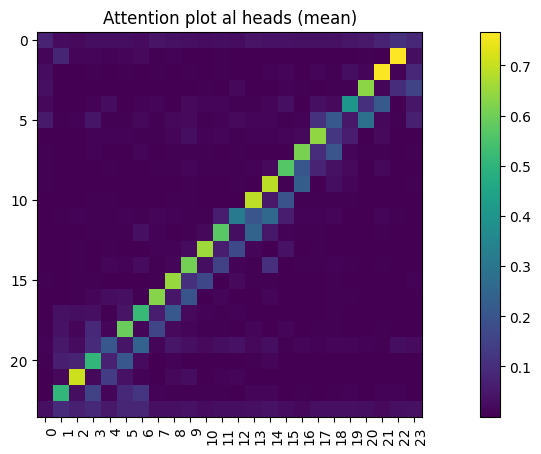

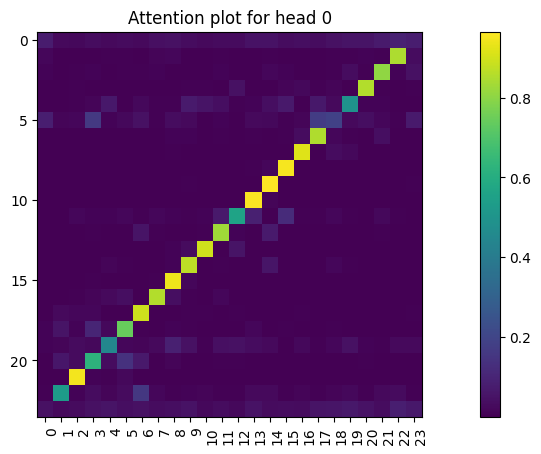

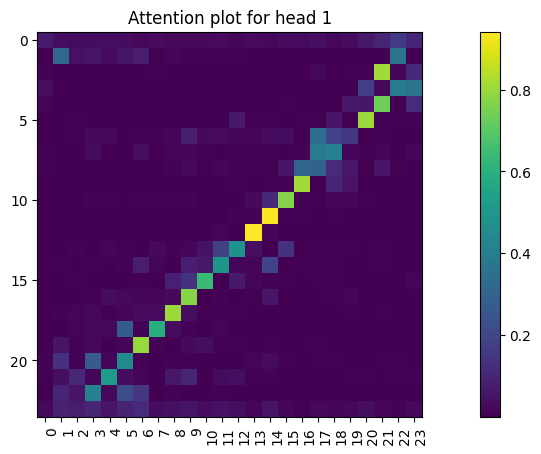

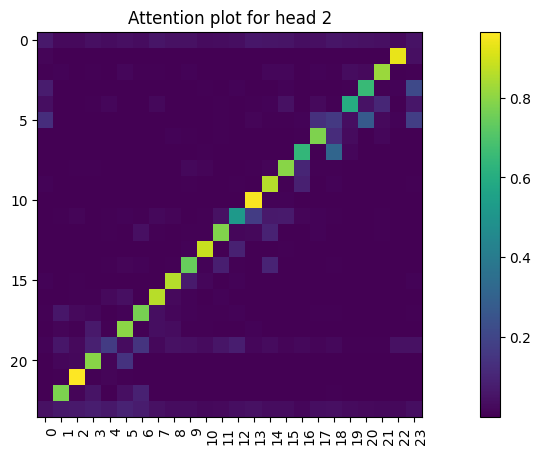

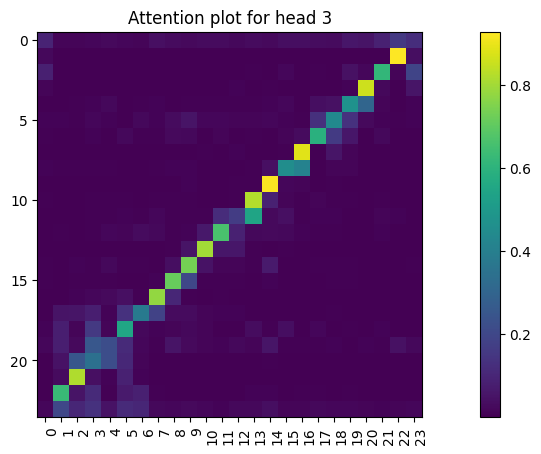

In [39]:
# plot attentions
w = model.transformer_blocks[0].attn2.attention_probs
# w = w.mean(0)
attention_plot(w.mean(0), title=f"Attention plot al heads (mean)")
for i in range(w.shape[0]):
        attention_plot(w[i], title=f"Attention plot for head {i}")


In [23]:
# print token correspondence between tgt & gen
for tgt, gen in zip([d["tgt"].split(" ") for d in data_piece], each_sample_list):
    print(f"----------")
    i = 0
    for t, g in zip(tgt, gen.split(" ")):
        print(f"{i}: {t} -> {g}")
        i += 1

----------
0: explosion -> explosion
1: mcdowell -> mcdowell
2: non -> non
----------
0: ェ -> ェ
1: slaves -> slaves
2: churchyard -> churchyard
3: intensity -> intensity
4: achieved -> achieved
5: publicized -> publicized
6: dissemination -> dissemination
7: europa -> europa
8: appropriately -> appropriately
9: charlton -> charlton
10: agrarian -> agrarian
11: eased -> eased
12: flavors -> flavors
13: mention -> mention
14: wehrmacht -> wehrmacht
15: explosion -> explosion
16: escaping -> escaping
17: transitional -> transitional
18: halftime -> halftime
19: irritation -> irritation
20: 332 -> 332
----------
0: ェ -> ェ
1: slaves -> slaves
2: churchyard -> churchyard
3: intensity -> intensity
4: achieved -> achieved
5: publicized -> publicized
6: dissemination -> dissemination
7: europa -> europa
8: appropriately -> appropriately
9: charlton -> charlton
10: agrarian -> agrarian
11: eased -> eased
12: flavors -> flavors
13: mention -> mention
14: elector -> mcdowell
15: wehrmacht -> wehrm